In [1]:
! pip install keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3419_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4176_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3370_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1255_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/660_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/484_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4221_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2396_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/543_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3017_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1482_left.jpg
/kaggle/input/ocular-disease-recognit

In [3]:
! pip install huggingface_hub

In [4]:
import numpy as np # array manipulation
import pandas as pd 
from tqdm import tqdm
from huggingface_hub import from_pretrained_keras # download the model
import keras # deep learning
from PIL import Image # Image processing

In [5]:
model = from_pretrained_keras("keras-io/lowlight-enhance-mirnet", compile=False)

config.json not found in HuggingFace Hub


Downloading:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.19M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/437M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/219k [00:00<?, ?B/s]

2023-01-30 20:47:34.161607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 20:47:34.162576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 20:47:34.163655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 20:47:34.164465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 20:47:34.165213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [6]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")

In [7]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [8]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [9]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values

In [10]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values

In [11]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [12]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=256
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
            image = keras.preprocessing.image.img_to_array(image)
            image = image.astype('float32') / 255.0
            image = np.expand_dims(image, axis = 0)
            output = model.predict(image)
            image = output[0] * 255.0
#             image = image.reshape((np.shape(image)[0],np.shape(image)[1],3))
            image = np.uint32(image)
            image = Image.fromarray(image.astype('uint8'),'RGB')
            
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [13]:
dataset = create_dataset(cataract,1)

  0%|          | 0/594 [00:00<?, ?it/s]2023-01-30 20:48:19.604413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-30 20:48:25.967695: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 594/594 [03:29<00:00,  2.83it/s]


In [14]:
len(dataset)

588

In [15]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [02:47<00:00,  2.98it/s]


In [16]:
len(dataset)

1088

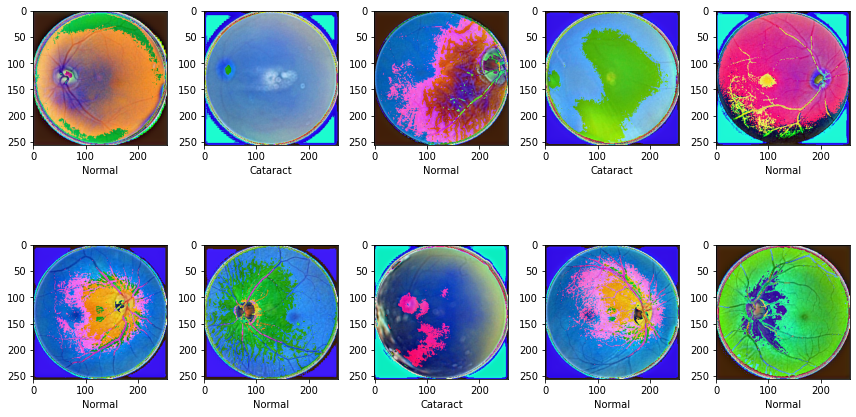

In [17]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 

In [18]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(weights="imagenet", input_shape=(image_size,image_size,3), include_top=False)

for layer in resnet.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [21]:
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization
x = Flatten() (resnet.output)
x = Dropout(0.5)(x) # Add a dropout layer with a rate of 0.5
x = BatchNormalization()(x) # Add a batch normalization layer
prediction = Dense(1, activation = 'relu')(x)
model = Model(inputs = resnet.input, outputs = prediction)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("resnet50.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [25]:
history = model.fit(x_train,y_train,batch_size=64,epochs=50,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/50
14/14 [==============================] - 11s 506ms/step - loss: 3.2163 - accuracy: 0.7724 - val_loss: 6.3128 - val_accuracy: 0.5780
Epoch 2/50
14/14 [==============================] - 4s 280ms/step - loss: 3.4864 - accuracy: 0.7632 - val_loss: 3.4592 - val_accuracy: 0.7615
Epoch 3/50
14/14 [==============================] - 4s 278ms/step - loss: 2.5474 - accuracy: 0.8333 - val_loss: 2.4592 - val_accuracy: 0.8349
Epoch 4/50
14/14 [==============================] - 4s 320ms/step - loss: 2.0651 - accuracy: 0.8598 - val_loss: 1.7720 - val_accuracy: 0.8761
Epoch 5/50
14/14 [==============================] - 4s 284ms/step - loss: 1.7739 - accuracy: 0.8816 - val_loss: 2.5677 - val_accuracy: 0.8257
Epoch 6/50
14/14 [==============================] - 4s 286ms/step - loss: 2.2666 - accuracy: 0.8471 - val_loss: 3.2337 - val_accuracy: 0.7752
Epoch 7/50
14/14 [==============================] - 4s 285ms/step - loss: 2.0850 - accuracy: 0.8621 - val_loss: 3.0479 - val_accuracy: 0.7982
Epoch

In [26]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 2s 115ms/step - loss: 0.8526 - accuracy: 0.9404
loss: 0.8526312708854675
Accuracy: 0.9403669834136963


In [27]:
!pip install scikit-learn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [28]:
# Obtain the predicted probability values for the test data
y_pred = model.predict(x_test)

# Convert the predicted probability values to class labels
y_pred = (y_pred > 0.5).astype(int)

In [29]:
accuracy_score(y_test,y_pred)

0.9403669724770642

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        98
           1       1.00      0.89      0.94       120

    accuracy                           0.94       218
   macro avg       0.94      0.95      0.94       218
weighted avg       0.95      0.94      0.94       218



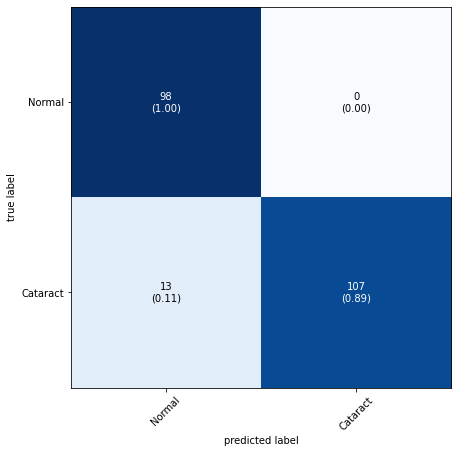

In [31]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

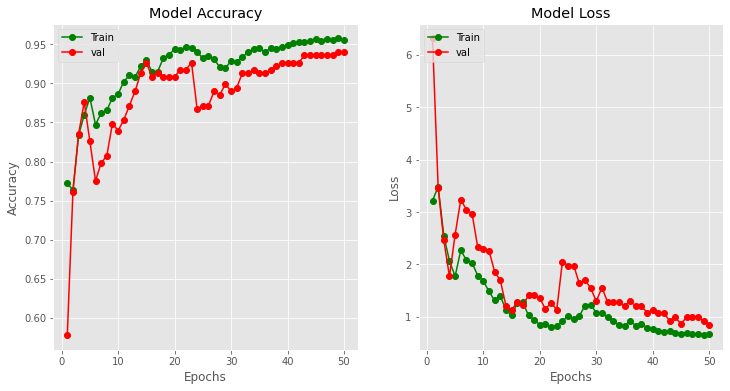

In [32]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,51)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()